# Chapter 6 Prediction


## 6.1 General Prediction Framework

Suppose that we are interested in predicting an <span style="color:red"> outcome, $y$,</span> using a set of features ${\bf  x}= (x_1, x_2, \ldots, x_p)^T$. In other words, we want to learn a function $f\left({\bf x},\boldsymbol{\beta}\right)$ that predicts $y$, where the function $f$ is indexed by a vector of parameters $\boldsymbol{\beta} \equiv \left(\beta_1,\ldots, \beta_p\right)$. The hope is that, for any new observation ${\bf x}^*= (x_1^*, x_2^*,\ldots, x_p^*)^T$, we can predict its outcome $y^*$ with $f({\bf x}^*,\boldsymbol{\beta})$.  To this end, we need to find the **best** $\boldsymbol{\beta}$ for predicting our data. In other words, we search for the vector $\boldsymbol{\beta}$ that minimizes $\mathbb{E}\left[L\left(y,  f\left({\bf x},\boldsymbol{\beta}\right) \right)\right]$, where $L(\cdot,\cdot)$ is the loss function or criterion of interest. 

We can summarize the framework of a general prediction problem as follows. 


1. Obtain a data set $\{(y_i,{\bf x}_i)\}_{i=1}^n$.
2. Choose a criterion $L(y, \hat{y})$ between the outcome and its predictor.
3. Choose a model $\hat{y}=f({\bf x},\boldsymbol{\beta})$ to produce the prediction. 
4. Find the $\hat{\boldsymbol{\beta}}$ that optimizes the criterion.
5. For any given new observations ${\bf x}^*$, predict its outcome with $f({\bf x}^*,\hat{\boldsymbol{\beta}})$.

There are many moving pieces in this framework, in particular, one needs to choose the criterion $L$ and the model $f$. We will visit a few classic examples in this chapter. 

In general, there are lots of candidate methods for building predictive models. There is no best method **overall**, but there often is a best method **for your data**. There are two keys for a method to do well on your data:
    
- It does not <span style="color:red"> completely</span> miss important structure
- It admits a proper amount of <span style="color:blue"> complexity</span> for the <span style="color:blue"> number of observations</span> in your data.

**Example: Hotel booking demand data.** As a motivating example, we consider the Hotel booking demand data from the Kaggle Open Datasets ([link](https://www.kaggle.com/jessemostipak/hotel-booking-demand)). This is a publicly available data set with [many suggestions](https://www.kaggle.com/jessemostipak/hotel-booking-demand/notebooks?datasetId=511638&sortBy=voteCount) on how to analysis it. We consider two questions in this chapter. 

1. As a customer, predict the average daily rate (`adr`) using available features.
2. As a hotel manager, predict the cancellation (`is_canceled`) using available features. 

In [3]:
library(tidyverse)
hotel <- read_csv("../Data/hotel_bookings.csv") %>% print



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  hotel = col_character(),
  arrival_date_month = col_character(),
  meal = col_character(),
  country = col_character(),
  market_segment = col_character(),
  distribution_channel = col_character(),
  reserved_room_type = col_character(),
  assigned_room_type = col_character(),
  deposit_type = col_character(),
  agent = col_character(),
  company = col_character(),
  customer_type = col_character(),
  reservation_status = col_character(),
  reservation_status_date = col_date(format = "")
)
i Use `spec()` for the full column specifications.




# A tibble: 119,390 x 32
   hotel is_canceled lead_time arrival_date_ye~ arrival_date_mo~
   <chr>       <dbl>     <dbl>            <dbl> <chr>           
 1 Reso~           0       342             2015 July            
 2 Reso~           0       737             2015 July            
 3 Reso~           0         7             2015 July            
 4 Reso~           0        13             2015 July            
 5 Reso~           0        14             2015 July            
 6 Reso~           0        14             2015 July            
 7 Reso~           0         0             2015 July            
 8 Reso~           0         9             2015 July            
 9 Reso~           1        85             2015 July            
10 Reso~           1        75             2015 July            
# ... with 119,380 more rows, and 27 more variables:
#   arrival_date_week_number <dbl>, arrival_date_day_of_month <dbl>,
#   stays_in_weekend_nights <dbl>, stays_in_week_nights <dbl>, adults <db

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."


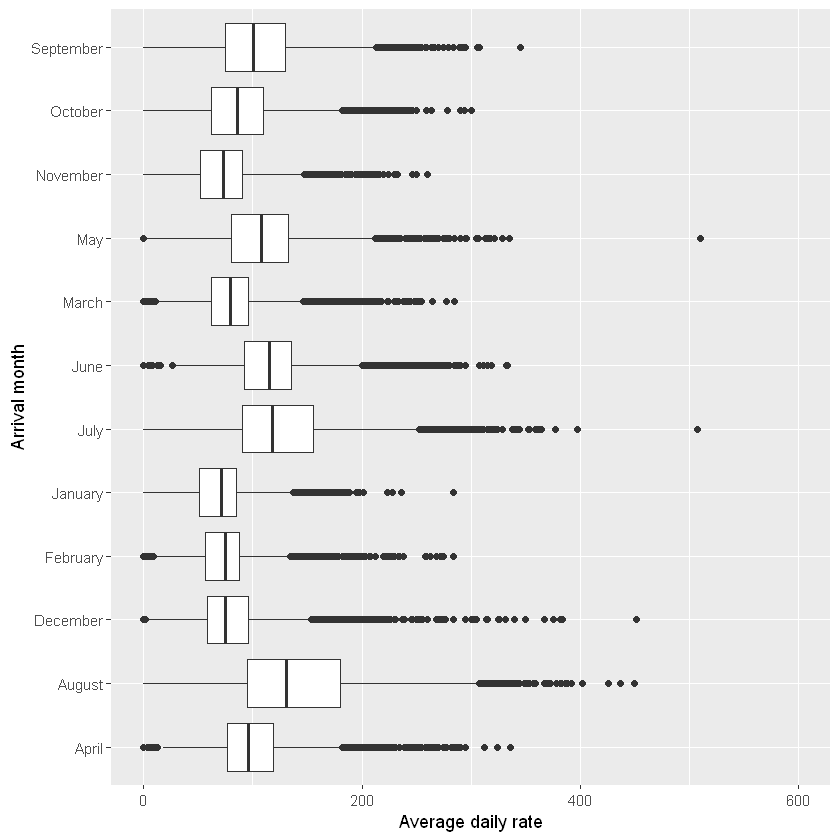

In [4]:
ggplot(data = hotel, aes(arrival_date_month, adr)) + 
    geom_boxplot() + ylim(0,600)+ ylab("Average daily rate")+xlab("Arrival month")+
    coord_flip()

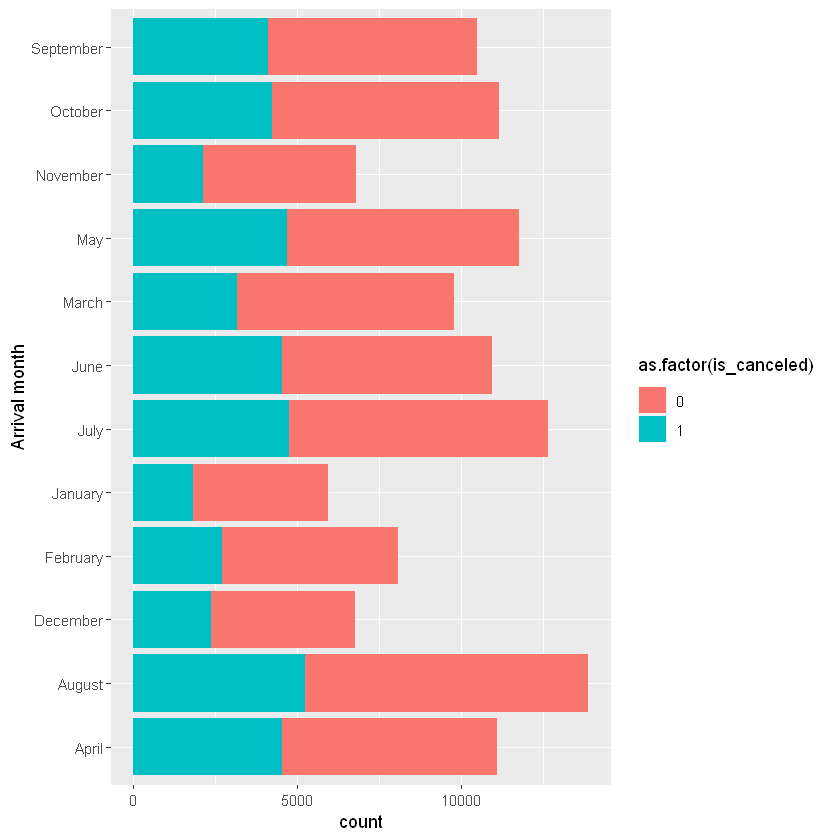

In [7]:
ggplot(data = hotel, aes(arrival_date_month, ..count..)) + 
    geom_bar(mapping = aes(fill=as.factor(is_canceled))) +xlab("Arrival month")+
    coord_flip()

In [9]:
# Consider a smaller set:
hotel<- hotel %>% select(is_canceled, adr, lead_time, total_of_special_requests, stays_in_week_nights, stays_in_weekend_nights, previous_cancellations)
hotel<- hotel %>% mutate(is_canceled = (is_canceled==1));
hotel<-hotel %>% filter(adr<1000)
hotel<-hotel[1:1000,]
hotel %>% print


# A tibble: 1,000 x 7
   is_canceled   adr lead_time total_of_specia~ stays_in_week_n~
   <lgl>       <dbl>     <dbl>            <dbl>            <dbl>
 1 FALSE          0        342                0                0
 2 FALSE          0        737                0                0
 3 FALSE         75          7                0                1
 4 FALSE         75         13                0                1
 5 FALSE         98         14                1                2
 6 FALSE         98         14                1                2
 7 FALSE        107          0                0                2
 8 FALSE        103          9                1                2
 9 TRUE          82         85                1                3
10 TRUE         106.        75                0                3
# ... with 990 more rows, and 2 more variables: stays_in_weekend_nights <dbl>,
#   previous_cancellations <dbl>


## 6.2 Criteria


### 6.2.1 Continuous outcomes

With continuous outcome, we often use the squared error, or the $\ell_2$-norm,  
$$
L\left( y, \hat{y}\right) = \|y-\hat{y}\|_2^2\equiv  \left( y - \hat{y}\right)^2.
$$

A famous example that uses this loss function is the least squares estimation for linear regression. In a linear regression, the function $f(X,\beta)$ takes the form 
$$
f(X,\beta)= \beta_1 x_1 + \ldots + \beta_p x_p.  
$$
The linear model is usually the place to start for building a predictive model. However, it is rare to have a truly linear relationship between the outcomes and features. The linear form is also very restrictive in modeling. Therefore, the linear model is almost always outperformed by more flexible models. Nevertheless, it is a simply model for us to start exploring predictive modeling. 

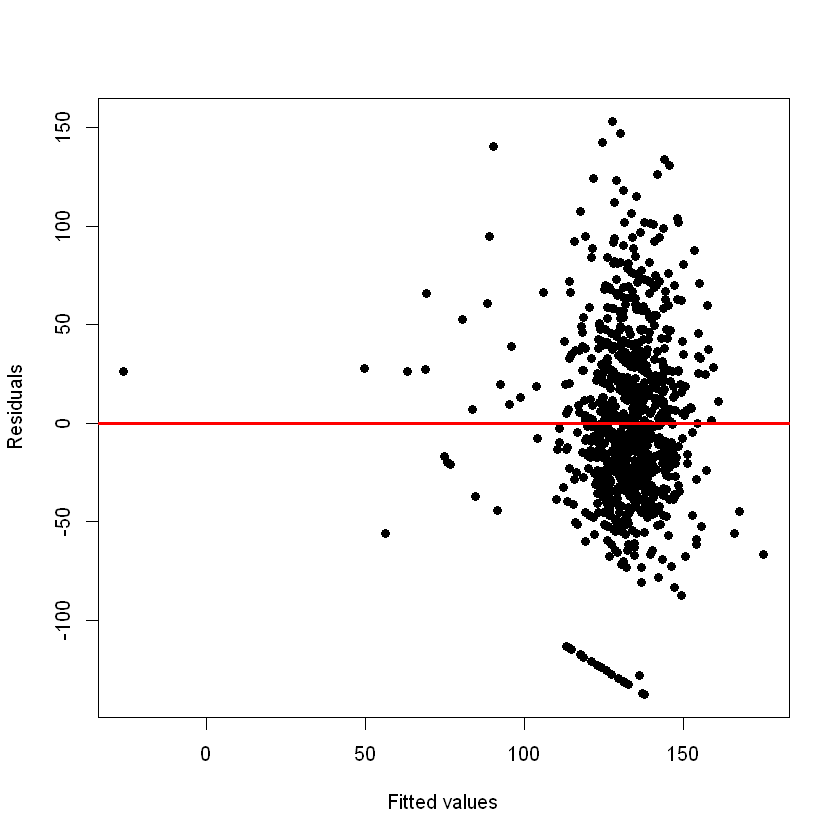

In [11]:
## Predicting ADR using a linear model 

mod.adr.lm<-lm(adr~lead_time+ total_of_special_requests+ stays_in_week_nights+ stays_in_weekend_nights+ previous_cancellations,data=hotel)

plot(mod.adr.lm$residuals~mod.adr.lm$fitted.values,pch=16,xlab="Fitted values", ylab="Residuals")
abline(h=0,lwd=3,col="red")


### 6.2.2 Binary outcomes 

With a binary outcome, we can adapt the squared error loss in the previous section by treating the outcome as $0$ and $1$. Alternatively, we can also take the the <span style="color:red"> likelihood </span> approach. The likelihood for observing $y \in \{0,1\}$ when $y$ is a Bernoulli random variable with probability $p$ is 
$$
L_1(y,p)= p^y (1-p)^{1-y}.
$$
For a binary outcome $y$, we will often model the probability $y = 1$ as $f(x,\beta)$, i.e., $p=\hat{y}=f(x,\beta)$. In addition, we generally consider the "log-likelihood" or the "negative-log-likelihood". These lead us to the negative-log-likelihood
$$
L_2\big( y,f(x,\beta)\big) = - y \cdot \log\left(\frac{ f(x,\beta)}{1-f(x,\beta) }\right) -\log\big(1- f(x,\beta) \big).
$$

It is slightly more traditional to model $g(x,\beta) = \log\left(\frac{f(x,\beta)}{1-f(x,\beta)}\right)$, since $g(x,\beta)$ takes values in the whole real line while $f(x,\beta)$ is restricted to live in $[0,1]$. For instance, we can assume that $g(x,\beta)= \beta_1 x_1 + \ldots + \beta_p x_p.$ This is equivalent to 
$$
    f(x) = \frac{e^{x_1\beta_1 + \ldots + x_p\beta_p}}{1+ e^{x_1\beta_1 + \ldots + x_p\beta_p}},
$$
which is known as the <span style="color:blue"> logistic</span> regression.


In [12]:
## Predicting cancellations with a logistic regression


mod.can.lg<-glm(is_canceled~adr+lead_time+ total_of_special_requests+ stays_in_week_nights+ stays_in_weekend_nights+  previous_cancellations,data=hotel,
               family="binomial")




[1] 0.09006211

[1] 0.05309735

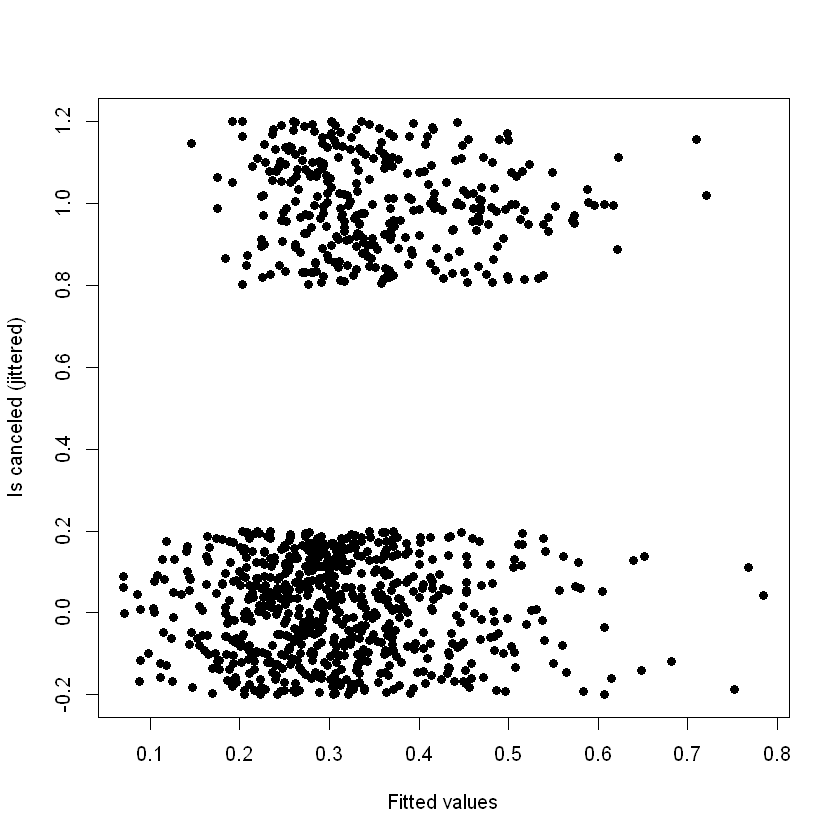

In [13]:

plot(jitter(mod.can.lg$y)~mod.can.lg$fitted.values,pch=16,xlab="Fitted values", ylab="Is canceled (jittered)")

threshold = 0.5;
TP= sum( (mod.can.lg$fitted.values>threshold) & mod.can.lg$y) ;
TN= sum((mod.can.lg$fitted.values<threshold) & (!mod.can.lg$y));


(TPR=TP/sum( mod.can.lg$y))
(FPR=1- TN/sum(!mod.can.lg$y))



### 6.2.3 Categorical outcome

If we observe categorical outcome, i.e., $y\in\{1,\ldots, K\}$. We can generalize the idea in the previous section by considering $K$ functions $f_1,\ldots, f_k$  and set the probabilty of $y = j$ as $f_j(x)/\sum_{k=1}^K f_k(x)$. 

We thus have the negative-log-likelihood
$$
L( y,  f_1(x),\ldots, f_K(x)) = -\log\left( f_{ y } (x)\right) + \operatorname{log}\left(\sum_{k=1}^K  f_k(x)\right)
$$
In this case, it is more traditional to model $g(x) = \log(f(x))$ which lives in the whole real line. 



**Classification.** With categorical outcomes, a prediction problem is also known as _classification_. To be specific, we might be interested in classifying observations into different categories. Naturally, the general prediction framework and prediction methods are applicable on the classification problems.  Other notable methods for classification include 
- Support vector machine.
- Linear discriminal analysis.
- k-nearest neighbours. 



## 6.3 Modeling

### 6.3.1 Meta-feature generation
	
We can create a nonlinear model with even only one single feature $x$. 

- <span style="color:red">Local smoothing:</span> For each $x$-value, estimate outcome with an average of observations with nearby $x$-values.

- <span style="color:blue"> Meta-feature construction:</span> Rather than just using $x$ as our one feature, we use e.g. $x, x^2, \ldots, x^5$ as features; and then set he model to be 
$$
    f(x,\beta) =\beta_1 x + \beta_2 x^2 + \ldots + \beta_5 x^5
$$
This is like doing  multiple regression  on $5$ features, where all 5 features are generated by the one $x$. 
    
    


For <span style="color:red">local smoothing</span> we now need a **distance** or **kernel** for multivariate ${\bf x}$ 
	
Often use Euclidean distance:
	$$
	D\big[\underbrace{\left( x_{1},x_{2} \right)}_{\textrm{observation $1$}}, \underbrace{\left( x_{1},x_{2} \right)}_{\textrm{observation $2$}}\big] \equiv \sqrt{\left( x_{1} - x_{1} \right)^2 + \left( x_{2}  -  x_{2} \right)^2}.
	$$
The Euclidean distance is equivalent to a Gaussian kernel with equal variance. We can also include weights or choosing different kernels for interesting data-types.


For continuous features various expansions may be used:

- Polynomial basis
$$
		\begin{pmatrix} \,\\x\\ \, \end{pmatrix}
		\rightarrow
		\begin{pmatrix}
		\, & \, & \, & \, \\ x, & x^2, & \cdots, &  x^m\\ \, & \, & \, & \,
		\end{pmatrix}
$$
        
- Spline basis
$$
		\begin{pmatrix} \,\\x\\ \, \end{pmatrix}
		\rightarrow
		\begin{pmatrix}
		\, & \, & \, & \, \\  x, &  \left(x - t_1\right)_{+}, & \cdots, & \left(x - t_m\right)_{+}\\ \, & \, & \, & \,
		\end{pmatrix}
$$

- Others include higher order spline, Fourier, wavelet, among others.




Same ideas can be employed with multiple features: 

- Additive: e.g. $( x_1 , x_2 ) \rightarrow ( x_1,x_1^2,x_1^3, x_2,x_2^2,x_2^3)$
- Interacting: e.g. $( x_1 ,x_2 ) \rightarrow ( x_1,x_1^2 ,  x_2,x_2^2 , x_1 x_2 ,  x_1^2 x_2  , x_1 x_2^2 )$

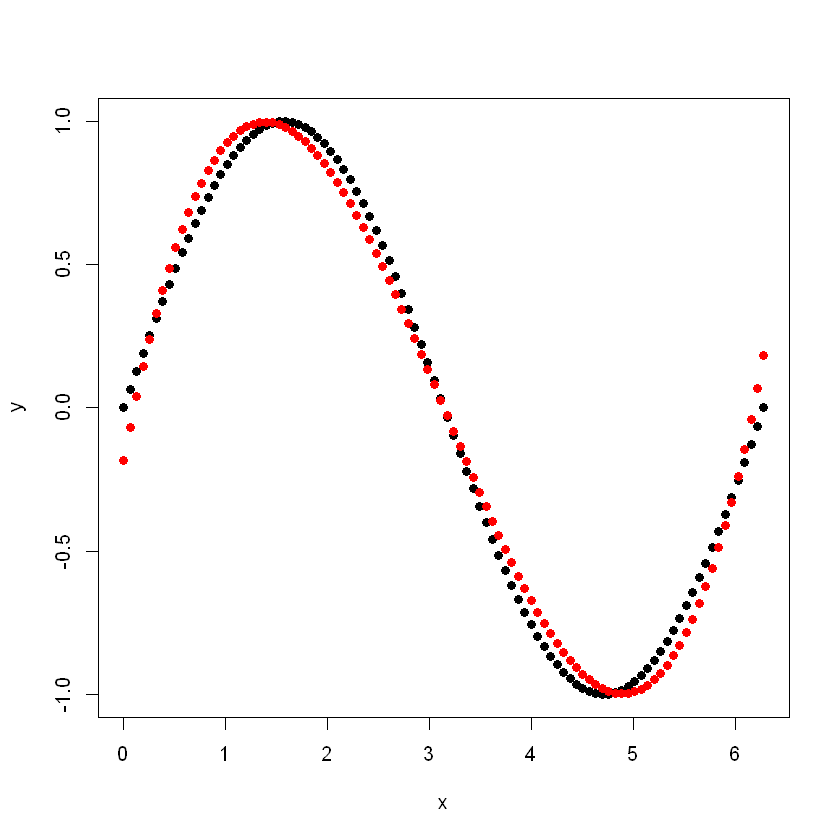

In [75]:

x<-seq(from=0,to=2*pi, length.out=100);
y<-sin(x);


M=3; 
x.expanded<-poly(x, degree = M,raw=F); # Set raw=T to see the raw polynomials 

mod.poly<-lm(y~x.expanded);

plot(y~x,pch=16)
points(y=mod.poly$fitted.values,x=x, pch=16,col="red")



### 6.3.2 Tree-Based Methods

The tree-based method (e.g., random forest) is a popular approach for building predictive models. A tree is likely an over-simplification of the true relationship. However, it is very easy to interpret, and has a nice graphical representation: you can easily explain it to a non-statistician, and do not need a computer (or even a calculator) to get an estimate!

The general steps for building a regression (or classification) tree is quite simple:

- **stratify** (or segment) the predictor space, i.e. the set of possible values for $X_1, X_2, \ldots, X_p$, into {\color{red} $J$ distinct and non-overlapping regions}, $R_1, R_2, \ldots, R_J$.

- Use the mean (regression) or mode (classification) of the response values for the training observations in region $R_j$ as the predicted response for that region.


   The main questions in this procedure are: <span style="color:red"> how should we construct the regions</span> $R_1, \ldots, R_J$, and <span style="color:red"> how many regions should we use</span>? 


Suppose $J$ is known. How to construct the regions $R_1, \ldots, R_J$?
- Divide the predictor space into high-dimensional <span style="color:red"> rectangles</span> or boxes (in theory any shape can be used, but this is simpler)
- Find boxes $R_1, \ldots, R_J$ that minimize the residual sum of squares
$$
L(y, \hat{y})=\sum_{j=1}^J \sum_{i \in R_j} (y_i - {\hat{y}_{R_j}})^2. 
$$
We can see that the criterion for a (regression) tree still takes the squared error form. 

Unfortunately, it is not possible to consider every possible partition of the space into $J$ boxes. We consider instead a *greedy* approach called <span style="color:blue"> recursive binary splitting</span>.  We take a top-down approach that is similar to hierarchical clustering. The best split is determined at each given step, instead of the best global step. In particular, at each step we do the following.                            
- For every $j=1,\ldots, p$, we choose  <span style="color:red">cut point</span> $t_j$ such that splitting the predictor space into regions
$$
 R_1(j, t_j) = \{ X \mid X_j < t_j\}, \ \ \  R_2(j, t) = \{ X \mid X_j \ge t_j\}.
$$
Here the $t_j$ is chosen as 
$$
\underset{t}{\arg\min} \sum_{i: x_i \in R_1(j,t)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j,t)} (y_i - \hat{y}_{R_2})^2
$$
- We find the value of $j$ with the smallest residual sum of squares 
$$
\sum_{i: x_i \in R_1(j,t_j)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j,t_j)} (y_i - \hat{y}_{R_2})^2. 
$$

We will repeat the above process to split a subspace (rather than the whole space) in each step. 

**Extensions of Trees **

We have considered the squared error loss. Similarly, trees can extend naturally to binary/survival data choose splits greedily to minimize loss.                          
                                                    
Trees are often used as <span style="color:blue"> base learners</span>
<span style="color:red"> model aggregation/ensembling</span>, e.g. boosting, bagging, stacking. 

Some `R` functions are better equipped to deal with high dimensional data ($p> n$) than others. Rarely will it hurt your method to prescreen out features that are extremely marginally uncorrelated with outcome.


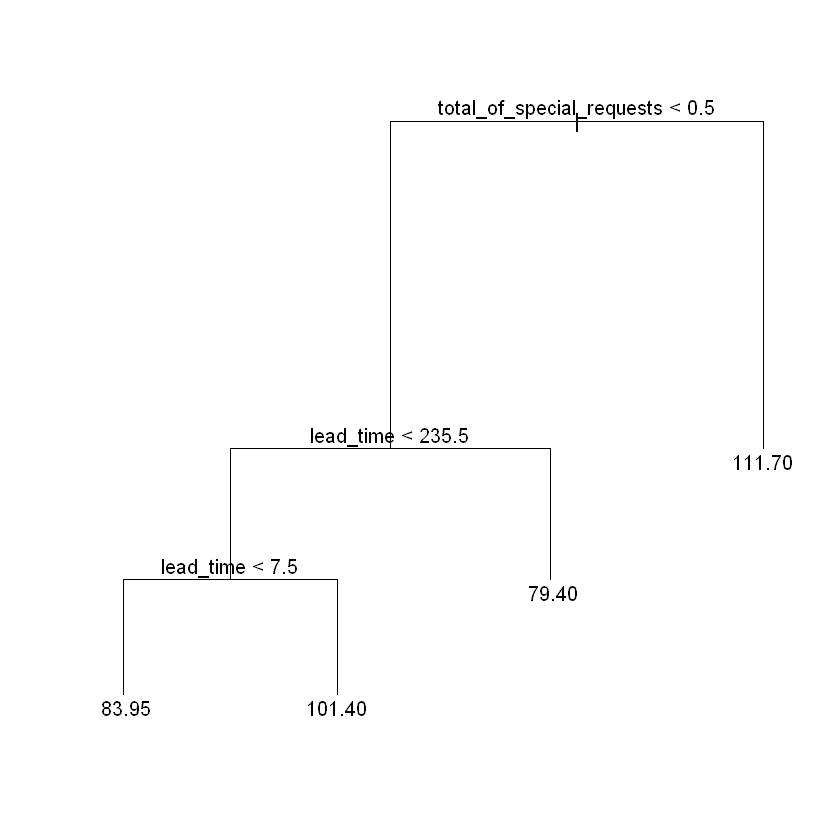

In [114]:
library(tree)

mod.adr.tree <- tree(adr~lead_time+ total_of_special_requests+ stays_in_week_nights+ stays_in_weekend_nights, data=hotel)
plot(mod.adr.tree)
text(mod.adr.tree, all=T, cex=0.8)

## 6.4 Model selection



### 6.4.1 Overview 

Model selection has many meanings. 

- It can mean selecting features and how they are to be included in the model. This is known as feature selection, and sometimes feature generation. 
- It can mean selecting the tuning parameters in e.g., penalized regression, decision trees, deep learning. This is also known as <span style="color:blue"> tuning parameter selection</span>
 - It can mean choosing between a range of models, for instance, regression tree (random forest), neural network (deep learning), or logistic regression. 
 
Recall that we have identified the criterion for deciding the "best" model. It is natural to wonder why not just pick the one model that minimizes that criterion. There are two important questions to address here. 

1. On what data to evaluate the criterion.
2. How to evaluate the criterion in a computational feasible way.


The first question is particular important. If the answer is to evaluate the criterion based on same data set, a phenomenon known as **overfitting** is inevitable. The game for model selection is essentially to avoid overfitting. 



### 6.4.2 Resctricting model complexity

Roughly speaking, the complexity of a model is tantamount to the number of parameters in the model. A model with more parameters is more flexible for learning the unknown mechanism, but at the same time may be sensitive to random patterns that are unique to this observed data set. A solution is to restrict the model complexity by penalizing the number of parameters. 



#### 6.4.2.1 Information criteria

The criterion in Section 6.2 places no constraint on the number of parameters. A classic strategy for avoiding overfitting is to supplement the loss function with a penalty on the **number of parameters**. Two very famous examples are the Akaike information criterion and the Bayesian information criterion. 

- Akaike information criterion (AIC): ${\rm AIC}=2k - \log (\hat{L}_k)$ where $k$ is the number of parameters and $\hat{L}_k$ is the likelihood function with $k$ parameters. 

- Bayesian information criterion (BIC): ${\rm BIC}=k\log(n) - \log (\hat{L}_k)$ where $k$ is the number of parameters and $\hat{L}_k$ is the likelihood function with $k$ parameters. 

The only difference between AIC and BIC is in the weights of $k$. In AIC, the weight is a constant 2, while in BIC the weight is $\log(n)$ that increases as the sample size increases. 


Both criteria capture the trade-off between the model complexity (i.e., $k$) and the goodness-of-fit (i.e., $\hat{L}_k$). Take AIC for example, AIC increases as the model become more complex (i.e., $k$ increases) and decreases as the model fits the data better (i.e., $\hat{L}_k$ increases and thus $-\log(\hat{L}_k)$ decreases). We will pick the model that yields the minimum information criterion among all competitors. 

#### 6.4.2.2 Penalization or regularization

In addition to restricting the number of parameters, we can also restrict the range of the parameters. This can be done by placing penalties on the magnitudes of the parameters. Two popular choices are the $\ell_1$-norm and $\ell_2$-norm on the parameters. 

- $\ell_1$-norm (lasso): $P(\beta_1,\ldots,\beta_p) = |\beta_1| + \ldots + |\beta_p|.$

- $\ell_2$-norm (ridge, Tikhonov): $P(\beta_1,\ldots,\beta_p) = \beta_1^2 + \ldots + \beta_p^2.$

We then choose $\beta_0,\beta_1,\ldots, \beta_k$, to minimize
	$$
	 L\left( y,  {\beta_0 + \beta_1 x_1 + ... +\beta_k x_k}\right) + \lambda P\left(\beta_1,\ldots,\beta_k\right),
	$$
where $\lambda$ modulates the degree of penalization. In other words, increasing $\lambda$ reults in a less complex model.  

Remark: For variable selection, the $\ell_0$-norm $P(\beta_1,\ldots,\beta_p) = 1_{[\beta_1\neq 0]} + \ldots + 1_{[\beta_p\neq 0]}$ is the ideal penalty, as it produces sparse estimates and causes no bias. However, it is computationaly intractable to solve the minimization problem when $\ell_0$-penalty is involved. 

In [ ]:
## Example with lasso and ridge
library(glmnet)
mod.can.lg.lasso <- glmnet(as.matrix(hotel[,-1]), hotel$is_canceled)


In [137]:
mod.can.lg.ridge <- glmnet(as.matrix(hotel[,-1]), hotel$is_canceled,alpha=0)

In [133]:
## Logistics with lasso penalty
mod.can.lg.lasso <- glmnet(as.matrix(hotel[,-1]), hotel$is_canceled, family = "binomial")

#### 6.4.2.3 Tree Pruning


 Complexity of the regression tree is determined by the number of regions $J$

- A tree with large $J$ may work well in training data, but would be very bad on test data
- A smaller tree with fewer splits might have lower variance and better interpretation at the cost of a little bias
- One option is to consider a split only if the drop in residual sum of squares is larger than some (high) threshold
- However, this may not be a good strategy since a so-so split at step $j$ may be followed by a great one at step $j+1$
- Instead, we <span style="color:blue"> first grow a large tree</span>, e.g. until no region has $>5$ observations, and then <span style="color:red"> prune</span> it to obtain a <span style="color:red"> subtree</span>
- And, again, we (basically) use <span style="color:red"> cross validation</span> to select $J$.



To prune a tree, we can use cross-validation, however, it will be too computationally expensive to estimate the CV error for every possible subtree. Instead we use a strategy called <span style="color:red"> cost complexity pruning</span> a.k.a. <span style="color:red"> weakest link pruning</span>. 

Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$. For each value of $\alpha$, there exists a subtree $T \subset T_0$ such that 
$$
\sum_{k=1}^{|T|}\sum_{x_i \in R_k} (y_i - \hat{y}_{R_k})^2 + \alpha |T|
$$
 is as small as possible ($|T|$ is the number of leaves of the tree). 
 
 Here  $\alpha$ controls the tradeoff between complexity and fit and we can select $\alpha$ using validation set or CV approach

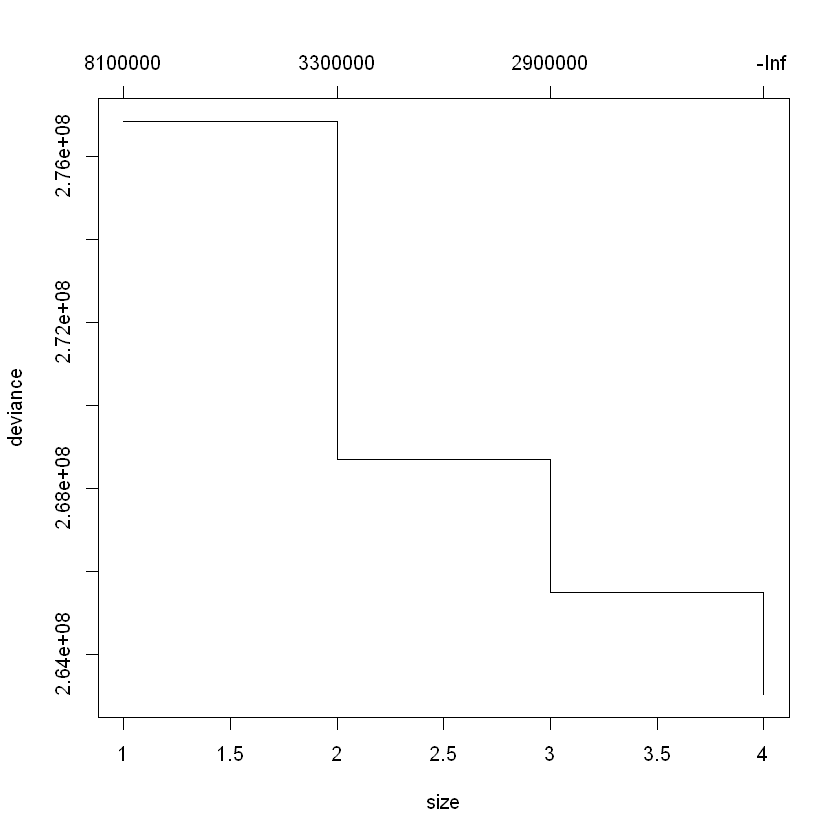

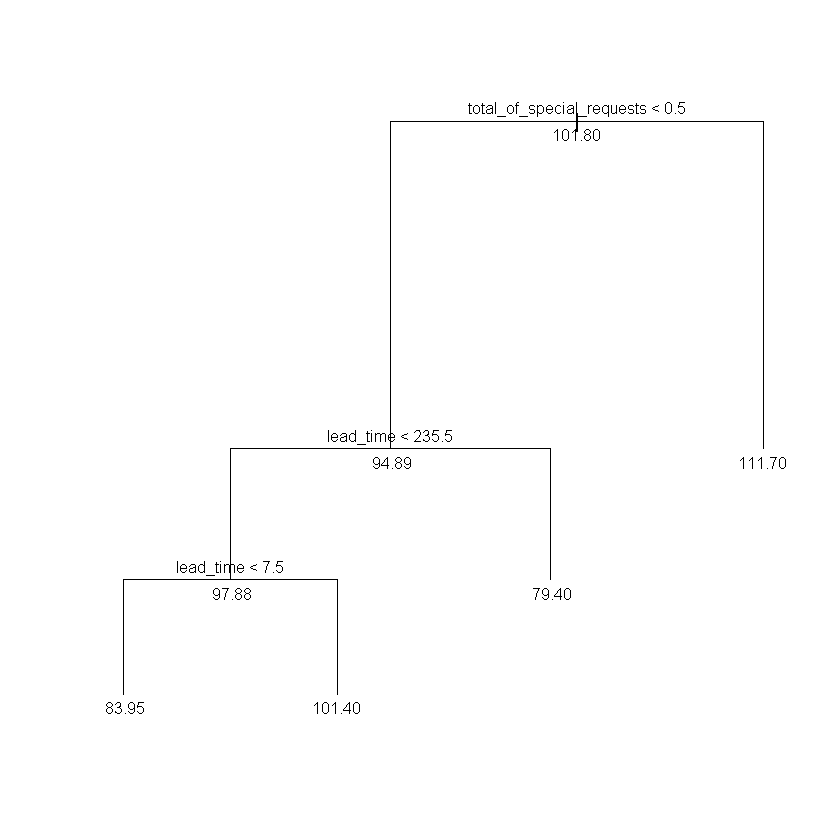

In [120]:
## Example of tree pruning:
mod.adr.tree.cv <- cv.tree(mod.adr.tree );
plot(mod.adr.tree.cv)


best_size = mod.adr.tree.cv$size[which.min(mod.adr.tree.cv$dev)];

mod.adr.tree.pruned=prune.tree(mod.adr.tree, best = best_size)

plot(mod.adr.tree.pruned)
text(mod.adr.tree.pruned, all=TRUE, cex=.8)


### 6.4.3 Split-sample validation 

Rather than constraining the complexity, we can directly deal with overfitting. The issue of overfitting is when the model over fits the random patterns in the data set, where these patterns will not be seen in the new observations. A straight-forward way to address this issue is to employ **independent Validation**. That is, the chosen criterion will be evaluated on an independent testing set, where the model is trained on a training set. 

In practice, we may not be able to collect a new set of data from the same population using the same sampling scheme. However, we can create the training-test sets from one data set. We can *randomly* split the data set into two sets, where $q\%$ of the data belong to the training set and $(1-q)\%$ the test set. When the split is random, it is reasonable to believe that the two sets share the same data generating mechanism. The split needs some careful thoughts when there are structures in the data (e.g., time series data). 

After splitting the data set into training set and test set, we can explore any models in the training set, and to evaluate their performance in the test data. 


Split sample validation protects against over-optimism due to fishing through hypotheses on the training data. However, split Sample Validation does not necessarily give a great estimate of performance "in the wild". For instance, 
- If all samples were run in one lab, your data cannot say how well things generalize to other labs
- Effects found in a subpopulation defined by one criteria may not reproduce if the subpopulation is defined by a different (but nominally similar) criteria.

**Example** Split Sample Validation - Lasso

For choosing $\lambda$ in the lasso...
- Split your data into a <span style="color:blue"> training</span> set and a <span style="color:orange"> validation</span> set
- Choose candidate $\lambda$-values ($\lambda_1,\ldots,\lambda_m$)
- For each candidate $\lambda$-value, fit your Lasso model on the <span style="color:blue"> training</span> data to get a set of coefficients
- Evaluate each of the $m$ sets of coefficients on your <span style="color:orange"> validation</span> data.

<span style="color:red"> Final Step):</span> Refit the Lasso model to **all the data**, using the best $\lambda$-value. 




More Generally

Suppose we are deciding between a <span style="color:blue"> neural network </span>, a <span style="color:red"> regression tree with depth $3$</span>, and a <span style="color:orange"> regression tree with depth $5$</span>.\\
- Split your data into a training set and a validation set
- For each of our $3$ procedures, build a predictive model on the training data
- Evaluate each of the $3$ predictive models on the validation data.

<span style="color:red"> Final Step:</span> Refit a predictive model to the full data, using the **best** procedure.

### 6.4.3 Cross-validation

The split-sample validation does not seem an efficient use of the data set. Only part of the data is used in training the model, and the other part produces estimates of the criterion with low precision due to limited sample size. 

How about "rotating" the roles of training and validation? For instance, we can split the data equally into two sets. We train the model on Set 1 and evaluate the fitted model on Set 2. Then, we train the model on Set 2 and evaluate the fitted model on Set 1. This way, all data are used at least once in fitting a model, and once in evaluating the model fitted from other data. In both cases, overfitting is curbed since training and validation happen on independent data sets. This procedure is known as **cross-validation**.

In general, the $K$-fold cross-validation works as follows. We randomly partition our data into $K$ non-overlapping sets, a.k.a. folds. Suppose that there are $K$ folds. Each time, we then use $1$ fold as the test set, and all $K-1$ folds as the training set. After iterating through all $K$ folds, we use the average criterion (e.g., loss function) from the $K$ iterations as the final performance measure of the procedure. We will pick the procedure with the best performance and refit the procedure on the full data set. 

A special case of cross-validation is the leave-one-out validation, where 1 observation is left out as the test set each time. 

[1] 6

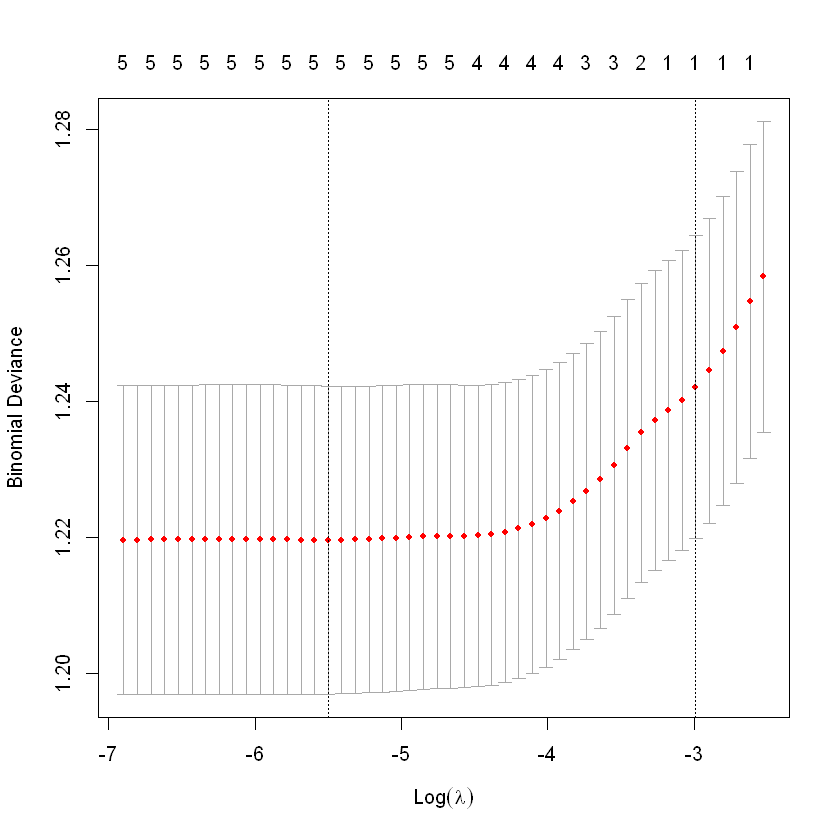

In [145]:
## Logistics with lasso penalty
mod.can.lg.lasso.cv <- cv.glmnet(as.matrix(hotel[,-1]), hotel$is_canceled, family = "binomial")
plot(mod.can.lg.lasso.cv)

## Report number of features included in the optimal model
sum(coef(mod.can.lg.lasso.cv, s = "lambda.min") != 0) 

## Find names of the selected features
coefs <- coef(mod.can.lg.lasso.cv, s = "lambda.min") 


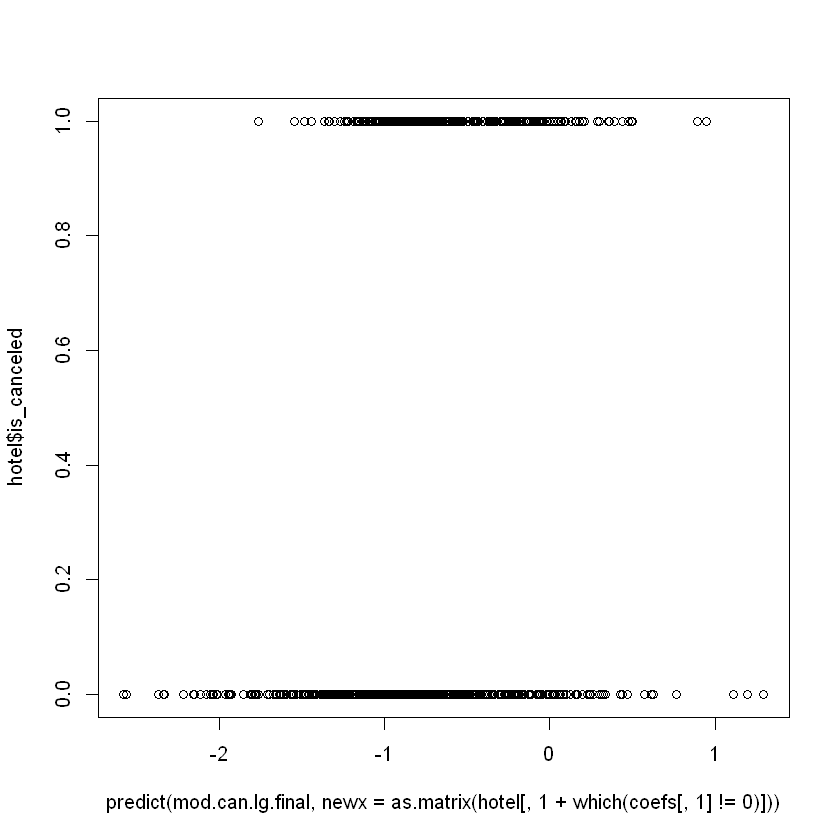

In [146]:
mod.can.lg.final<-glmnet(as.matrix(hotel[,1+which(coefs[,1]!=0) ]), hotel$is_canceled, family = "binomial",lambda=0)
plot(x=predict(mod.can.lg.final,newx=as.matrix(hotel[,1+which(coefs[,1]!=0) ])),y=hotel$is_canceled)